# Devoir 1
    Frederick Auger-Morin
    Mohamed Chibane

## 3 Partie pratique : estimation de densité

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import utilitaires

In [242]:
data = np.loadtxt("iris.txt")

In [243]:
# 3.1 Implémentez un estimateur de densité paramétrique Gaussien diagonal.
# En se basant sur ce qui a été vu durant le labo:

class gauss_mv:
    def __init__(self,n_dims,cov_type="diagonale"):
        self.n_dims = n_dims
        self.mu = np.zeros((1,n_dims))
        self.cov_type = cov_type
        if cov_type =="isotropique":
            self.sigma_sq = 1.0
        elif cov_type=="diagonale":
            self.sigma_sq = np.ones(n_dims)
        elif cov_type=="full":
            self.sigma_sq = np.ones((n_dims,n_dims))
            
    def train(self, train_data):
        self.mu = np.mean(train_data, axis = 0)
        if self.cov_type == "isotropique":
            self.sigma_sq = np.sum((train_data - self.mu)**2.0) / (self.n_dims * train_data.shape[0])
        elif self.cov_type == "diagonale":
            self.sigma_sq = np.sum((train_data - self.mu)**2.0,axis=0) / train_data.shape[0]
        elif self.cov_type == "full":
            self.sigma_sq = np.cov(np.transpose(train_data))
    
    def compute_predictions(self, test_data):

        if self.cov_type == "isotropique":
            # log(constante de normalisation)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - self.n_dims*np.log(self.sigma_sq)/2.0
            # il faut calculer la valeur de la log-probabilite de chaque exemple
            # de test sous le modele determine par mu et sigma_sq. le vecteur
            # des probabilites est/sera log_prob
            if self.n_dims > 1:
                log_prob = c - np.sum((test_data -  self.mu)**2.0,axis=1) / (2.0 * self.sigma_sq)
            else:
                log_prob = c - (test_data -  self.mu)**2.0 / (2.0 * self.sigma_sq)
                
        elif self.cov_type == "diagonale":
            # on prend le produit du vecteur représentant la diagonale (np.prod(self.sigma)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - np.log(np.prod(self.sigma_sq))/2.0
            # on somme sur l'axe 1 après avoir divisé par sigma puisque celui ci aussi est
            # de dimension d
            log_prob = c - np.sum((test_data -  self.mu)**2.0/ (2.0 * self.sigma_sq),axis=1)
        elif self.cov_type == "full":
            c = -self.n_dims * np.log(2.0*np.pi)/2.0
            det = np.linalg.det(self.cov)
            c += np.log(det)/2.0
            
            dmu = test_data-self.mu
            inv = np.linalg.inv(self.cov)
            
            dxs = np.dot(dmu,inv)
            dxsx = np.sum(dxs*dmu,axis=1)
            log_prob = c - dxsx
        return log_prob

In [253]:
# 3.2 Implémentez un estimateur de densité de Parzen à noyau Gaussien isotropique.
class parzen_gauss:
    def __init__(self,n_dims,sigma_sq=1.0,cov_type="isotropique"):
        self.n_dims = n_dims
        self.cov_type = "isotropique"
        if cov_type =="isotropique":
            self.sigma_sq = sigma_sq
            
    def train(self, train_data):
        if self.cov_type =="isotropique":
            # On calcule d'abord la fonction de densité gaussienne isotropique centrée sur le point d'entrainement
            # Chaue gaussienne estimee de dimension n_dims est centree en mu qui sonty nos points dentrainement.
            self.mus = train_data
               
    def compute_predictions(self, test_data):
        if self.cov_type == "isotropique": 
            # pour tous les points test, on doit calculer la densitee
            # la constante de normalization
            c = np.log((1/self.n_dims)*(1/(2*np.pi)**(self.n_dims/2.0))*self.sigma_sq**self.n_dims)
            
            log_prob = np.zeros(test_data.shape[0]) 
            if self.n_dims > 1:
                i = 0
                # Pour chaque point de l'ensemble de test, on doit faire la somme de toutes les densites
                for point in test_data:
                    log_prob[i]= c + np.log(np.sum(np.sum(np.power(point-self.mus,2),axis=1)/(-2*self.sigma_sq)))
                    i+=1
            else:
                i = 0
                # Pour chaque point de l'ensemble de test, on doit faire la somme de toutes les densites
                for point in test_data:
                    log_prob[i]= c + np.log(np.sum(np.exp(np.power(point-self.mus,2)/(-2*self.sigma_sq))))
                    i+=1
    
        return log_prob

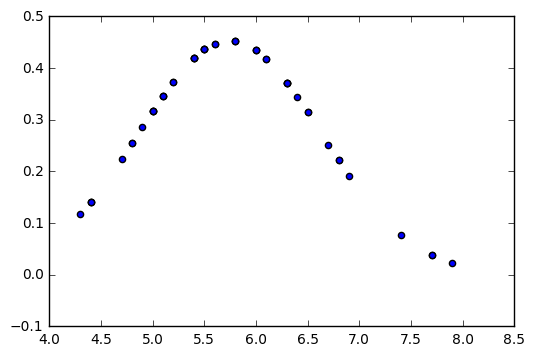

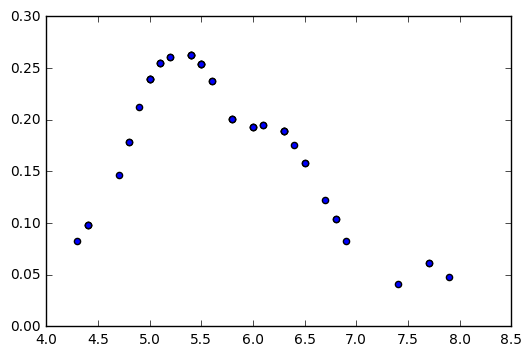

In [254]:
# 3.3 Densités 1D
d=1
partial_data= np.zeros((50,1))

partial_data = data[0:50,0] # on chosit la classe 1 et le premier feature



mdl_gauss = gauss_mv(1,cov_type="isotropique")
mdl_gauss.train(partial_data)

densite_gauss = mdl_gauss.compute_predictions(partial_data)


plt.scatter(partial_data, np.exp(densite_gauss))
plt.show()

mdl_parzen = parzen_gauss(d,.05)
mdl_parzen.train(partial_data)
densite_parzen = mdl_parzen.compute_predictions(partial_data)

plt.scatter(partial_data,np.exp(densite_parzen))
plt.show()


## 4 Partie pratique : classifieur de Bayes

In [255]:
# 4.1 : On melange les exemples d'iris
np.random.seed(123)
np.random.shuffle(data)
train = data[0:100] #100/150 pour le training
valid = data[100:] #50/150 pour la valid

part_train = train[:,[0,1,-1]] #on conserve seulement les deux premieres dimension et le label
part_valid = valid[:,[0,1,-1]]

In [256]:
# 4.2 : Classifieur de Bayes basé sur des densités paramétriques Gaussiennes diagonales 
class classif_bayes:

    def __init__(self,modeles_mv, priors):
        self.modeles_mv = modeles_mv
        self.priors = priors
        if len(self.modeles_mv) != len(self.priors):
            print 'Le nombre de modeles MV doit etre egale au nombre de priors!'
        
        self.n_classes = len(self.modeles_mv)
                                                            
    # Retourne une matrice de taille nb. ex. de test x nombre de classes contenant les log
    # probabilités de chaque exemple de test sous chaque modèle MV. 
    def compute_predictions(self, test_data, eval_by_group=False):
        log_pred = np.empty((test_data.shape[0],self.n_classes))

        for i in range(self.n_classes):
            # ici il va falloir utiliser modeles_mv[i] et priors pour remplir
            # chaque colonne de log_pred (c'est plus efficace de faire tout une
            # colonne a la fois)
            
            log_pred[:,i] = self.modeles_mv[i].compute_predictions(test_data) +  self.priors[i]

        return log_pred

Taux d'erreur sur l'ensemble d'entrainement: 19.00%
Taux d'erreur sur l'ensemble de validation: 28.00%


c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0760D2B0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0760D870>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x075B6CB0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


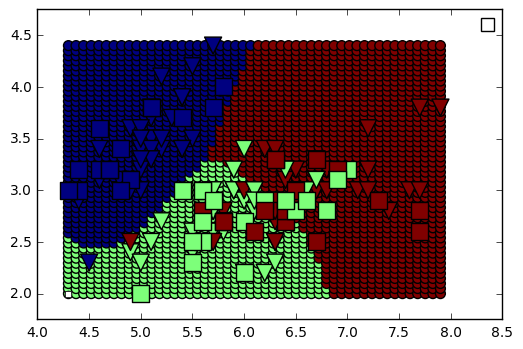

In [257]:
# 4.2 b) On entraine sur les 2 premiers traits caracteristiques et on visualise
d = 2
model_class1 = gauss_mv(d)
model_class2 = gauss_mv(d)
model_class3 = gauss_mv(d)

pt_class1 =[] #pt for part_train
pt_class2 =[]
pt_class3 =[]
for ex in part_train:
    if ex[-1] == 1:
        pt_class1.append(ex)
    elif ex[-1] == 2:
        pt_class2.append(ex)
    elif ex[-1] == 3:
        pt_class3.append(ex)
        
pt_class1 = np.asarray(pt_class1)
pt_class2 = np.asarray(pt_class2)
pt_class3 = np.asarray(pt_class3)

#on entraine le MV sur la partition des donnees de training

model_class1.train(pt_class1[:,:-1])
model_class2.train(pt_class2[:,:-1])
model_class3.train(pt_class3[:,:-1])

models = [model_class1,model_class2,model_class3]

# Nos priors pour chaque classe seront simplement le nombre d'exemple de chaque test dans l'ensemble aleatoire de training
totEx = float(len(part_train))
priors = [float(len(pt_class1))/totEx,float(len(pt_class2))/totEx,float(len(pt_class3))/totEx]

classifier_1 = classif_bayes(models,priors)
log_prob_train = classifier_1.compute_predictions(part_train[:,:-1])
log_prob_valid = classifier_1.compute_predictions(part_valid[:,:-1])

classesPred_train = log_prob_train.argmax(axis=1)+1
classesPred_valid = log_prob_valid.argmax(axis=1)+1

print "Taux d'erreur sur l'ensemble d'entrainement: %.2f%%" % ((1-(classesPred_train==part_train[:,-1]).mean())*100.0)
print "Taux d'erreur sur l'ensemble de validation: %.2f%%" % ((1-(classesPred_valid==part_valid[:,-1]).mean())*100.0)

utilitaires.gridplot(classifier_1,part_train,part_valid)

In [258]:
# 4.2 d) On entraine de la meme facon mais en utilisant tous les features (d = 4) au lieu des deux premiers

d = 4
model_class1 = gauss_mv(d)
model_class2 = gauss_mv(d)
model_class3 = gauss_mv(d)

class1 =[] #pt for part_train
class2 =[]
class3 =[]
for ex in train:
    if ex[-1] == 1:
        class1.append(ex)
    elif ex[-1] == 2:
        class2.append(ex)
    elif ex[-1] == 3:
        class3.append(ex)
        
class1 = np.asarray(class1)
class2 = np.asarray(class2)
class3 = np.asarray(class3)

#on entraine le MV sur la partition des donnees de training

model_class1.train(class1[:,:-1])
model_class2.train(class2[:,:-1])
model_class3.train(class3[:,:-1])

models = [model_class1,model_class2,model_class3]

# Nos priors pour chaque classe seront simplement le nombre d'exemple de chaque test dans l'ensemble aleatoire de training
totEx = float(len(train))
priors = [float(len(class1))/totEx,float(len(class2))/totEx,float(len(class3))/totEx]

classifier_1 = classif_bayes(models,priors)
log_prob_train = classifier_1.compute_predictions(train[:,:-1])
log_prob_valid = classifier_1.compute_predictions(valid[:,:-1])

classesPred_train = log_prob_train.argmax(axis=1)+1
classesPred_valid = log_prob_valid.argmax(axis=1)+1

print "Taux d'erreur sur l'ensemble d'entrainement: %.2f%%" % ((1-(classesPred_train==train[:,-1]).mean())*100.0)
print "Taux d'erreur sur l'ensemble de validation: %.2f%%" % ((1-(classesPred_valid==valid[:,-1]).mean())*100.0)

Taux d'erreur sur l'ensemble d'entrainement: 5.00%
Taux d'erreur sur l'ensemble de validation: 4.00%


In [259]:
#4.3 Classifieur de Bayes basé sur des densités de Parzen avec noyau Gaussien isotropique
class classif_bayes_parzen:
    def __init__(self,modeles_parzen, priors):
        self.modeles_parzen = modeles_parzen
        self.priors = priors
        if len(self.modeles_parzen) != len(self.priors):
            print 'Le nombre de modeles de fenetres de Parzen doit etre egale au nombre de priors!'
        
        self.n_classes = len(self.modeles_parzen)
                                                            
    # Retourne une matrice de taille nb. ex. de test x nombre de classes contenant les log
    # probabilités de chaque exemple de test sous chaque modèle avec fenetres de Parzen. 
    def compute_predictions(self, test_data, eval_by_group=False):
        log_pred = np.empty((test_data.shape[0],self.n_classes))

        for i in range(self.n_classes):
            # ici il va falloir utiliser modeles_mv[i] et priors pour remplir
            # chaque colonne de log_pred (c'est plus efficace de faire tout une
            # colonne a la fois)
            
            log_pred[:,i] = self.modeles_parzen[i].compute_predictions(test_data) +  self.priors[i]

        return log_pred

c:\Python27\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: divide by zero encountered in log
c:\Python27\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in log


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Taux d'erreur sur l'ensemble d'entrainement: 65.00%
Taux d'erreur sur l'ensemble de validation: 70.00%


c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x07621DB0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0767FC30>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x07621A50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


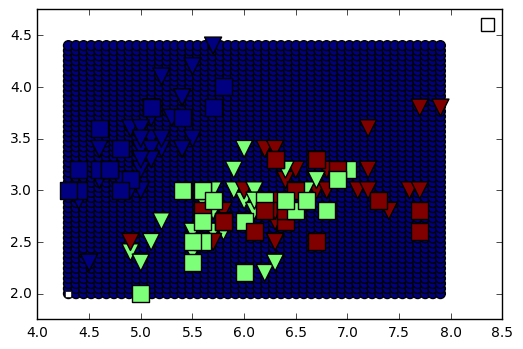

In [261]:
# 4.3 b) On entraine sur les 2 premiers traits caracteristiques et on visualise
d = 2
model_class1 = parzen_gauss(d,10)
model_class2 = parzen_gauss(d,10)
model_class3 = parzen_gauss(d,10)

pt_class1 =[] #pt for part_train
pt_class2 =[]
pt_class3 =[]
for ex in part_train:
    if ex[-1] == 1:
        pt_class1.append(ex)
    elif ex[-1] == 2:
        pt_class2.append(ex)
    elif ex[-1] == 3:
        pt_class3.append(ex)
        
pt_class1 = np.asarray(pt_class1)
pt_class2 = np.asarray(pt_class2)
pt_class3 = np.asarray(pt_class3)

#on entraine les fenetres de Parzen sur la partition des donnees de training

model_class1.train(pt_class1[:,:-1])
model_class2.train(pt_class2[:,:-1])
model_class3.train(pt_class3[:,:-1])

models = [model_class1,model_class2,model_class3]

# Nos priors pour chaque classe seront simplement le nombre d'exemple de chaque test dans l'ensemble aleatoire de training
totEx = float(len(part_train))
priors = [float(len(pt_class1))/totEx,float(len(pt_class2))/totEx,float(len(pt_class3))/totEx]

classifier_2 = classif_bayes_parzen(models,priors)
log_prob_train = classifier_2.compute_predictions(part_train[:,:-1])
log_prob_valid = classifier_2.compute_predictions(part_valid[:,:-1])

classesPred_train = log_prob_train.argmax(axis=1)+1
classesPred_valid = log_prob_valid.argmax(axis=1)+1
print classesPred_train
print "Taux d'erreur sur l'ensemble d'entrainement: %.2f%%" % ((1-(classesPred_train==part_train[:,-1]).mean())*100.0)
print "Taux d'erreur sur l'ensemble de validation: %.2f%%" % ((1-(classesPred_valid==part_valid[:,-1]).mean())*100.0)

utilitaires.gridplot(classifier_2,part_train,part_valid)